# Spatial Weights

In this session we will learn about spatial weight matrices. Spatial weight matrices are structured set of numbers that formalize Geographical Relationships between observations in a dataset.

$$W=\begin{bmatrix} 0 & w_{12} & \dots & w_{1N}\\ w_{21} & \ddots & w_{ij} & \vdots \\ \vdots & w_{ji} & 0 & \vdots \\ w_{1N} & \dots & \dots & 0 \end{bmatrix}$$

Each cell *w*<sub><i>ij</i> </sub> represents the degree of interaction between the observations *i* and *j*. By convention we set the diagonal elements of *W* as zero. We define *j* as a *neighbor* of *i* if *i* has some degree of *connection* with *j*. In terms of the Weight Matrix *W* *j* is a *neighbor* of *i* if *w*<sub><i>ij</i> </sub>>0. And from the defintion for *neighbor* we could define *neighborhood* of *i* as the set of observations in the system with which it has certain connection, or those observations with a weight greater than zero.

There are many ways of creating Weight Matrix *W* which we will explore now. We will mainly use the libraries <span style="background-color:#C5C5C5">*Geopandas*</span> and <span style="background-color:#C5C5C5">*PySAL*</span> for this workshop

In [16]:
%matplotlib inline

import seaborn as sns
import pandas as pd
from pysal.lib import weights
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## Data
We will be using the Ohio Counties Data for this session.

In [17]:
#load the Ohio Counties data to geopandas dataframe
oh_counties=gpd.read_file(r'../class_data/Ohio_counties/ODOT_County_Boundaries.shp')
#set the index as FIPS_COUNT as it is the unique id for a county

In [18]:
#let's see what columns are there in this dataset
oh_counties.columns

Index(['OBJECTID', 'COUNTY_CD', 'COUNTY_SEA', 'ODOT_DISTR', 'FIPS_COUNT',
       'POP_2010', 'POP_2000', 'POP_1990', 'STATE_PLAN', 'ELEVATION_',
       'ELEVATION1', 'LAT_NORTH_', 'LAT_SOUTH_', 'LONG_EAST_', 'LONG_WEST_',
       'AREA_SQMI', 'AREA_ID', 'created_us', 'created_da', 'last_edite',
       'last_edi_1', 'SHAPE_STAr', 'SHAPE_STLe', 'geometry'],
      dtype='object')

In [19]:
#lets see the values in some columns
oh_counties[['COUNTY_CD','COUNTY_SEA','POP_2010','geometry']]

,COUNTY_CD,COUNTY_SEA,POP_2010,geometry
0,HIG,HILLSBORO,43589,"POLYGON ((-83.78330 39.26382, -83.78312 39.263..."
1,HOC,LOGAN,29380,"POLYGON ((-82.49595 39.60265, -82.49505 39.612..."
2,HOL,MILLERSBURG,42366,"POLYGON ((-81.87727 40.66713, -81.87564 40.667..."
3,HUR,NORWALK,59626,"POLYGON ((-82.83547 41.14407, -82.83549 41.145..."
4,FRA,COLUMBUS,1163414,"POLYGON ((-83.24596 39.96574, -83.24595 39.965..."
...,...,...,...,...
83,VIN,MCARTHUR,13435,"POLYGON ((-82.51710 39.36942, -82.51595 39.379..."
84,WAR,LEBANON,212693,"POLYGON ((-83.98859 39.44441, -83.98941 39.435..."
85,HAS,CADIZ,15864,"POLYGON ((-81.27273 40.36923, -81.27271 40.369..."
86,PIC,CIRCLEVILLE,55698,"POLYGON ((-82.84304 39.56150, -82.84164 39.561..."


In [20]:
#lets see the first five values for the above 3 columns
oh_counties[['COUNTY_CD','COUNTY_SEA','POP_2010','geometry']].head()

,COUNTY_CD,COUNTY_SEA,POP_2010,geometry
0,HIG,HILLSBORO,43589,"POLYGON ((-83.78330 39.26382, -83.78312 39.263..."
1,HOC,LOGAN,29380,"POLYGON ((-82.49595 39.60265, -82.49505 39.612..."
2,HOL,MILLERSBURG,42366,"POLYGON ((-81.87727 40.66713, -81.87564 40.667..."
3,HUR,NORWALK,59626,"POLYGON ((-82.83547 41.14407, -82.83549 41.145..."
4,FRA,COLUMBUS,1163414,"POLYGON ((-83.24596 39.96574, -83.24595 39.965..."


In [21]:
#lets see what is the projection for this dataset
oh_counties.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
'''The dataset seems to be unprojected (Geographic coordinates).
Lets project it to UTM 17N (EPSG:26917) (Actually OHIO has a portion of UTM 16 and UTM 17. 
For convenince we are just using UTM 17N)'''
oh_counties_proj=oh_counties.to_crs('EPSG:26917')

In [23]:
#notice the change in geometry for the unprojected and projected dataset
print (oh_counties.geometry.head())
print ('-------------------------------')
print (oh_counties_proj.geometry.head())

0    POLYGON ((-83.78330 39.26382, -83.78312 39.263...
1    POLYGON ((-82.49595 39.60265, -82.49505 39.612...
2    POLYGON ((-81.87727 40.66713, -81.87564 40.667...
3    POLYGON ((-82.83547 41.14407, -82.83549 41.145...
4    POLYGON ((-83.24596 39.96574, -83.24595 39.965...
Name: geometry, dtype: geometry
-------------------------------
0    POLYGON ((259868.086 4349746.506, 259883.508 4...
1    POLYGON ((371566.374 4384725.994, 371662.147 4...
2    POLYGON ((425850.094 4502175.870, 425987.560 4...
3    POLYGON ((345967.492 4556373.871, 345967.376 4...
4    POLYGON ((308181.220 4426369.903, 308181.822 4...
Name: geometry, dtype: geometry


## Creating Weights
### Contiguos Neighbors
#### Rook Contiguity
Refers to neighbors sharing a common edge<br><br>
<img src="../images/Rook.png" width=400 height=400 />

/opt/conda/envs/py39/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 39171.
  warnings.warn(message)


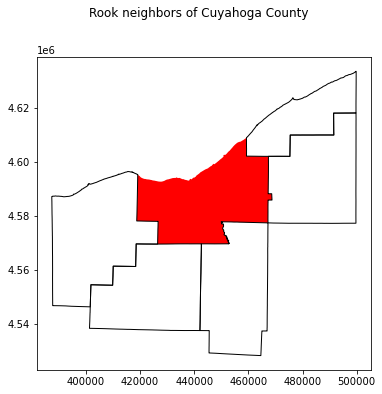

In [24]:
w_rook = weights.Rook.from_dataframe(oh_counties_proj,idVariable="FIPS_COUNT")
f, ax = plt.subplots(1, figsize=(6, 6))
focus = oh_counties_proj.loc[oh_counties_proj.FIPS_COUNT=='39035']
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
neis = oh_counties_proj.loc[oh_counties_proj.FIPS_COUNT.isin(w_rook.neighbors['39035'])]
neis.plot(ax=ax, facecolor='None', linewidth=1)
f.suptitle("Rook neighbors of Cuyahoga County")
plt.show()

#### Queen Contiguity
Refers to neighbors sharing a vertex<br><br>
<img src="../images/Queen.png" width=400 height=400 />

/opt/conda/envs/py39/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 39171.
  warnings.warn(message)


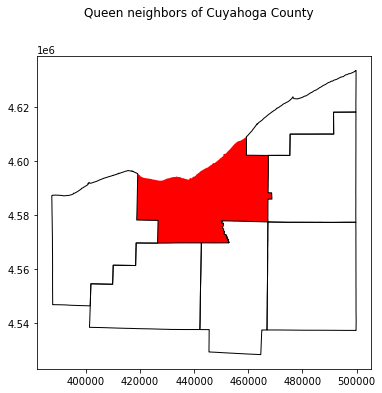

In [25]:
w_queen = weights.Queen.from_dataframe(oh_counties_proj,idVariable="FIPS_COUNT")
f, ax = plt.subplots(1, figsize=(6, 6))
focus = oh_counties_proj.loc[oh_counties_proj.FIPS_COUNT=='39035']
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
neis = oh_counties_proj.loc[oh_counties_proj.FIPS_COUNT.isin(w_queen.neighbors['39035'])]
neis.plot(ax=ax, facecolor='None', linewidth=1)
f.suptitle("Queen neighbors of Cuyahoga County")
plt.show()

### Distance
Assign weight to each pair of observation based on how far they are from each other
#### *k*-Nearest Neighbors
In a *k*-nearest neighbor definition, all units among the *k* nearest neighbors of unit *i* are treated as neighbors of *i*, while the remaining units are treated as non-neighbors.
An example may be that the typical citizen is able to retain the political argument of only five neighbors, at maximum, and is able to retain the political arguments of only five neighbors, and that these neighbors with whom political discussion takes place are the individuals five most spatially proximate neighbors.

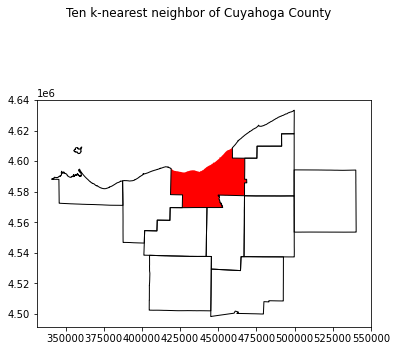

In [27]:
w_knn = weights.KNN.from_dataframe(oh_counties_proj, k=10)
f, ax = plt.subplots(1, figsize=(6, 6))
focus = oh_counties_proj.iloc[oh_counties_proj[oh_counties_proj.FIPS_COUNT=='39035'].index]
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
neis = oh_counties_proj.iloc[w_knn.neighbors[oh_counties_proj[oh_counties_proj.FIPS_COUNT=='39035'].index[0]]]
neis.plot(ax=ax, facecolor='None', linewidth=1)
f.suptitle("Ten k-nearest neighbor of Cuyahoga County")
plt.show()

#### Distance band
A distance band neighbor defintion will be theoretically supported if the researcher believes that units within a particular distance of unit *i* exhibit *spatial autocorrelation* with unit *i* but that units beyong this critical distance are spatially independent from unit *i*

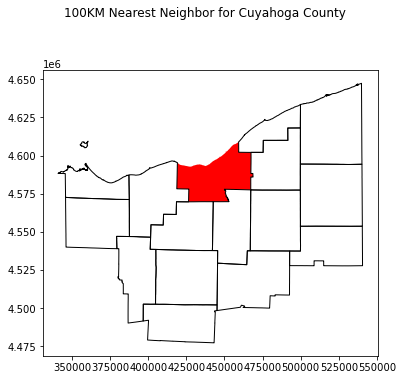

In [28]:
w_dist50kmB = weights.DistanceBand.from_dataframe(oh_counties_proj, 100000)
f, ax = plt.subplots(1, figsize=(6, 6))
focus = oh_counties_proj.iloc[oh_counties_proj[oh_counties_proj.FIPS_COUNT=='39035'].index]
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
neis = oh_counties_proj.iloc[w_dist50kmB.neighbors[oh_counties_proj[oh_counties_proj.FIPS_COUNT=='39035'].index[0]]]
neis.plot(ax=ax, facecolor='None', linewidth=1)
f.suptitle("100KM Nearest Neighbor for Cuyahoga County")
plt.show()

#### Distance-Decay
The distance band definition treated all neighbors within a certain distance of unit *i* as having same weights, and thus exerts the same influence on measures of spatial autocorrelation as each other. This may not be true as per Tobler's first Law of Geography which states that 
<blockquote> Everything is related to everything else, but near things are more related than distant things.</blockquote>
This conception of spatial autocorrelation can be estimated via a distance-decay neighbor definition. 
$$w_{ij} = d_{ij}^{-a}$$
where <i>d</i><sub><i>ij</i></sub> is the distance between contiguos units and positive value for parameter <i>a</i> give greater weight to the units that are more spatially proximate

/opt/conda/envs/py39/lib/python3.9/site-packages/scipy/sparse/data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


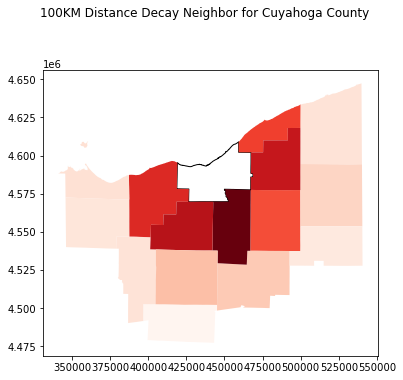

In [31]:
w_dist50kmC = weights.DistanceBand.from_dataframe(oh_counties_proj, 100000,binary=False)
f, ax = plt.subplots(1, figsize=(6, 6))
focus = oh_counties_proj.iloc[oh_counties_proj[oh_counties_proj.FIPS_COUNT=='39035'].index]
focus.plot(facecolor='None', alpha=1, linewidth=1, ax=ax)
neis = oh_counties_proj.iloc[w_dist50kmC.neighbors[oh_counties_proj[oh_counties_proj.FIPS_COUNT=='39035'].index[0]]]
wts=np.asarray(w_dist50kmC.weights[oh_counties_proj[oh_counties_proj.FIPS_COUNT=='39035'].index[0]])
wts=wts/np.max(wts)
neis.assign(weights=wts).plot(ax=ax, linewidth=1,column='weights', cmap='Reds')
f.suptitle("100KM Distance Decay Neighbor for Cuyahoga County")
plt.show()

### Nonspatial Weights
"<b>Space is more than geography</b>" and shared language, social distance, and small world networks are examples in which the dependence between observations may be <b>unrelated to geographic distance</b>. For eg degree of interdependence between countries may be affected by economic interdependence. 


## Standardizing Weight matrices
For spatial analysis techniques, a spatial weights matrix with raw values may not be suitable. This implies modifying each weight so they conform to certain rules. 

In [24]:
#queen weight for Cuyahoga county neighbors
print (w_queen.weights['39035'])
#Apply row standardization for weights
w_queen.transform ='R'
print (w_queen.weights['39035'])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
('WARNING: ', '39171', ' is an island (no neighbors)')
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
